# all things maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
import os
import pickle

import cartopy.crs as ccrs

import helper_functions

In [2]:
import matplotlib
matplotlib.style.use('default')

# read data

In [3]:
# temporary
[ERA5_ECMWF, 
 ERA5_IITM, 
 ERA5_ECMWF_deps, 
 ERA5_ECMWF_lows, 
 ERA5_IITM_deps, 
 ERA5_IITM_lows] = helper_functions.load_from_pickle('data/update/models_joined_with_era5.pickle')

ERA5 = helper_functions.load_from_pickle('data/update/era5.pickle')
ECMWF = helper_functions.load_from_pickle('data/update/ecmwf.pickle')
IITM = helper_functions.load_from_pickle('data/update/iitm.pickle')

In [56]:
for key,df in ERA5.items():
    
    # using this mask instead of pd.df.asfreq('6h') because if the storm starts at an 03:00,
    #    .asfreq will make it 03:00, 09:00, 15:00, etc. instead of 06:00, 12:00, 18:00, etc.
    mask_downsample = (df['date'].dt.hour % 6 == 0) # downsample to 6-hourly
    df = df.loc[mask_downsample]

    ERA5[key] = df

# helper functions + maps

## only density histogram

In [4]:
def track_density_map(lons, lats, densityTorF, minval, maxval, 
                               mapTitle='Track', maxY=9):
    
    fig = plt.figure(figsize=[6, 6])
    
    # create map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([82, 87, 15, 22])
    ax.stock_img()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines =False
    
    # plot data points
    if densityTorF == True:
        plt.hist2d(lons, lats, bins=[20,15], range=[[60, 100], [0, 30]], 
                   density = True, cmin = minval, vmax = maxval, cmap = plt.cm.YlOrBr)
    else:
        plt.hist2d(lons, lats, bins=[40,30], range=[[60, 100], [0, 30]], 
                   density = False, cmin = 1, vmax = maxY, cmap = plt.cm.jet)
    
    ax.set_title(mapTitle, fontsize=17)    
    plt.colorbar(fraction=0.04, pad=0.04).set_label('Density of track points')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    plt.show()

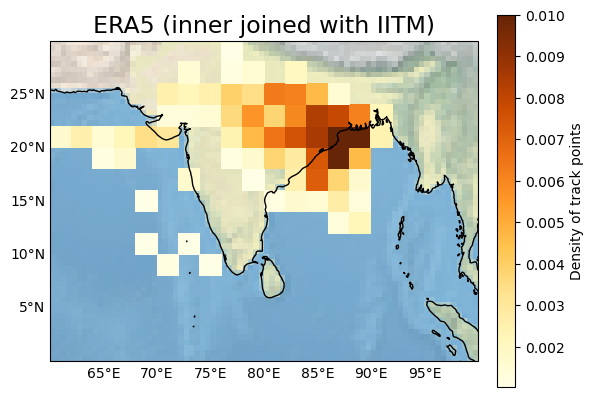

In [5]:
lons = pd.concat([df['Longitude_era5'] for key, df in ERA5_IITM.items()]).tolist()
lats = pd.concat([df['Latitude_era5'] for key, df in ERA5_IITM.items()]).tolist()

track_density_map(lons, lats, True, .001, .01, 'ERA5 (inner joined with IITM)')

## density histogram with tracks

In [6]:
def plot_histogram_and_tracks(dic, lons_var, lats_var, year_to_plot_tracks, maptitle):
    
    fig = plt.figure(figsize=[6, 6])

    # create map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([82, 87, 15, 22])
    #ax.stock_img()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines =False

    # plot density histogram
    lons = pd.concat([df[lons_var] for key, df in dic.items()]).tolist()
    lats = pd.concat([df[lats_var] for key, df in dic.items()]).tolist()
    plt.hist2d(lons, lats, bins=[20,15], range=[[60, 100], [0, 30]], 
               density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)

    # plot tracks
    keys_year = [key for key in list(dic.keys()) if key[:4]==year_to_plot_tracks]
    
    for key in keys_year:
        df = dic[key]
        track_lons = df[lons_var]
        track_lats = df[lats_var]
        plt.plot(track_lons.iloc[0], track_lats.iloc[0], color='grey', marker='.', markersize=10,
                         transform=ccrs.Geodetic())
        plt.plot(track_lons, track_lats, color='grey', linewidth=0.5,linestyle='solid',
                         transform=ccrs.Geodetic(),)

    ax.set_title(maptitle, fontsize=17)    
    plt.colorbar(fraction=0.04, pad=0.04).set_label('Density of track points')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    plt.show()

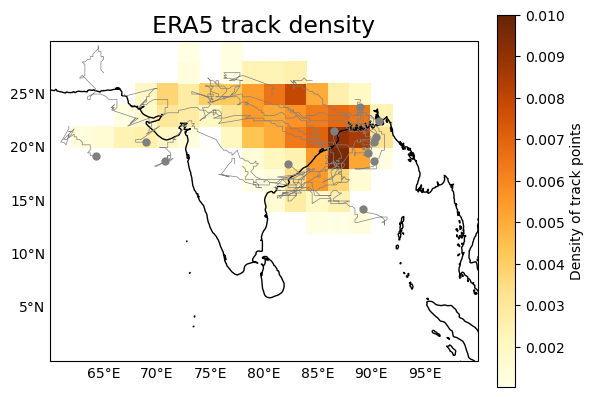

In [7]:
# do we want to plot ERA5 or ERA5_ECMWF
plot_histogram_and_tracks(ERA5, 'Longitude', 'Latitude', '2007',
                          'ERA5 track density')

## three-panel density histogram with (no) tracks

In [84]:
# https://stackoverflow.com/questions/69465435/cartopy-show-tick-marks-of-axes
# https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

def format_ax(ax, ax_label):
    ax.coastlines()
    ax.set_extent([50, 95, 10, 35])
    ax.annotate(ax_label, xy=(0, 1.035), xycoords='axes fraction', fontname='Dejavu Sans', fontsize=14)
    
    ax.set_xticks([65, 75, 85, 95], crs=ccrs.PlateCarree())
    ax.set_yticks([15, 20, 25], crs=ccrs.PlateCarree())
    
    ax.tick_params(axis='both', labelsize=14)
    
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    
    # gl.xlabel_style = {'size': 20}
    # gl.ylabel_style = {'size': 20}

In [97]:
def plot_hist_and_tracks(ax, fig, dic, lons_var, lats_var, title, year_to_plot_tracks):
    
    # plot density histogram
    lons = pd.concat([df[lons_var] for key, df in dic.items()]).tolist()
    lats = pd.concat([df[lats_var] for key, df in dic.items()]).tolist()
    # hist_ax = ax.hist2d(lons, lats, bins=[20,15], range=[[60, 100], [10, 30]], 
    #                      density = False, cmin=1, vmax=100, cmap = plt.cm.YlOrBr)
    ax.set_title(title, fontname='Dejavu Sans', fontsize=16)
    hist_ax = ax.hist2d(lons, lats, bins=[20,10], range=[[60, 100], [10, 30]], 
                         density = False, cmin=.001, vmax=115, cmap = plt.cm.YlOrBr) # cmin = .001, vmax = .01,
    # fig.colorbar(hist_ax[3], ax=ax, pad=0.05, shrink=.69, aspect=20) #fraction=0.04
        #.set_label("Density of track points")
    
    # plot tracks NOT DOING THIS FOR NOW
#     keys_year = [key for key in list(dic.keys()) if key[:4]==year_to_plot_tracks]
    
#     for key in keys_year:
#         df = dic[key]
#         track_lons = df[lons_var]
#         track_lats = df[lats_var]
        
#         color='blue'
#         ax.plot(track_lons.iloc[0], track_lats.iloc[0], color=color, marker='.', markersize=10,
#                          transform=ccrs.Geodetic())
#         ax.plot(track_lons, track_lats, color=color, linewidth=1,linestyle='solid',
#                          transform=ccrs.Geodetic())
        
    return hist_ax

In [98]:
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import ticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

/global/homes/s/salilg/.conda/envs/xarrayenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/global/homes/s/salilg/.conda/envs/xarrayenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/global/homes/s/salilg/.conda/envs/xarrayenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


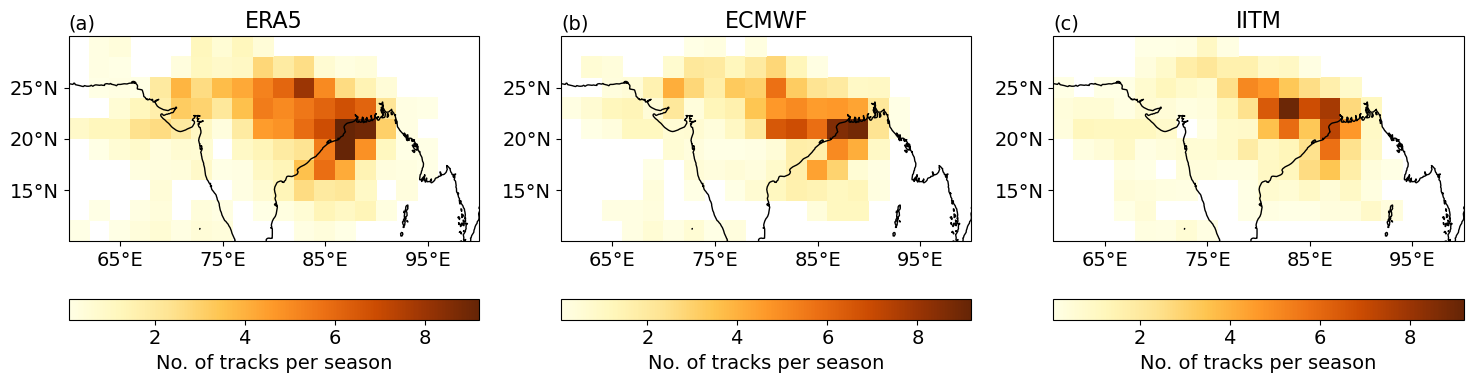

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, subplot_kw={'projection': ccrs.PlateCarree()}, 
                                    figsize=[18,5])

ticklabelsize=14

format_ax(ax1, '(a)')
format_ax(ax2, '(b)')
format_ax(ax3, '(c)')

tick_locator = ticker.MaxNLocator(nbins=5) # for the colorbar
tick_locator1 = ticker.MaxNLocator(nbins=5) # for the colorbar

hist_ax = plot_hist_and_tracks(ax1, fig, ERA5, 'Longitude', 'Latitude', 'ERA5', '2007')
cbar1 = fig.colorbar(hist_ax[3], ax=ax1, orientation='horizontal',)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=ticklabelsize)
original_ticks = cbar1.get_ticks() 
cbar1.ax.set_xticklabels((original_ticks / 12).astype(int)) # divide by number of years 2007-2018
cbar1.set_label('No. of tracks per season', fontsize=14)

hist_ax = plot_hist_and_tracks(ax2, fig, ECMWF, 'Longitude', 'Latitude', 'ECMWF', 
                               '2007')
cbar2 = fig.colorbar(hist_ax[3], ax=ax2, orientation='horizontal')
cbar2.locator = tick_locator
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=ticklabelsize)
original_ticks = cbar2.get_ticks() 
cbar2.ax.set_xticklabels((original_ticks / 12).astype(int)) # divide by number of years 2007-2018
cbar2.set_label('No. of tracks per season', fontsize=14)

hist_ax = plot_hist_and_tracks(ax3, fig, IITM, 'Longitude', 'Latitude', 'IITM', '2007')
cbar3 = fig.colorbar(hist_ax[3], ax=ax3, orientation='horizontal',) #fraction=0.025, 
             #pad=0.04)#.set_label("Density of track points")
cbar3.locator = tick_locator
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=ticklabelsize)
original_ticks = cbar3.get_ticks() 
cbar3.ax.set_xticklabels((original_ticks / 12).astype(int)) # divide by number of years 2007-2018
cbar3.set_label('No. of tracks per season', fontsize=14)
    
# plt.tick_params(axis='both', which='major', labelsize=34)

# fig.subplots_adjust(right = 0.8)
# cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.05])
# cbar_ax = fig.add_axes([.83, .2, .02, .4])

# hist2d returns 4 things, the fourth one is the image, hence need index 3
# fig.colorbar(hist_ax[3], ax=cbar_ax, fraction=0.036, pad=0.04)
# fig.colorbar(hist_ax[3], ax=cbar_ax, shrink=5)

# plt.savefig('Figures/figures_10052022/2d_density_heatmap.pdf', 
#             format='pdf', bbox_inches='tight')

# make 1D histogram of track lengths, genesis and lysis times

vision: have 3 panels
- first panel: four KDE curves (one for each of ERA5, MERRA2, ECMWF, IITM)
- second panel: four KDE curves (one for ECMWF genesis minus ERA5 genesis, ECMWF genesis minus MERRA2 genesis, and same for IITM)
- third panel: four KDE curves (one for ECMWF lysis minus ERA5 lysis, ECMWF lysis minus MERRA2 lysis, and same for IITM

In [63]:
from KDEpy import FFTKDE

In [64]:
# df represents one track
def get_track_length(df):
    return (df['date'].iloc[-1] - df['date'].iloc[0]).total_seconds()/3600

# returns list of track lengths
def get_track_lengths_dic(dic):
    return [get_track_length(df) for key,df in dic.items()]

In [65]:
len(ERA5), len(ECMWF), len(IITM)#, len(MERRA2)

(137, 117, 103)

In [66]:
track_lengths_dic = {'ERA5': get_track_lengths_dic(ERA5),
                     'ECMWF': get_track_lengths_dic(ECMWF),
                     'IITM': get_track_lengths_dic(IITM)}

track_lengths_dic = dict([(key, pd.Series(value)) for key,value in track_lengths_dic.items()])

track_lengths_df = pd.DataFrame(track_lengths_dic)

In [67]:
track_lengths_df.mean(axis=0)

ERA5     140.145985
ECMWF    111.435897
IITM     116.854369
dtype: float64

In [68]:
track_lengths_df.max(axis=0)

ERA5     504.0
ECMWF    240.0
IITM     240.0
dtype: float64

In [24]:
# track_lengths_df.plot(kind='kde', 
#                       xlim=(0, 500), 
#                       title='distribution of track lengths')

In [25]:
# bins = np.linspace(0, track_lengths_df.max().max(), 80)
# #plt.hist(track_lengths_df['ERA5'], bins, alpha=0.5, label='ERA5')
# plt.hist(track_lengths_df['ECMWF'], bins, alpha=0.5, label='ECMWF')
# plt.hist(track_lengths_df['IITM'], bins, alpha=0.5, label='IITM')
# plt.legend()
# plt.show()

In [69]:
def get_genesis_time_bias(key, model, obs):
    return (model[key]['date'].iloc[0] - obs[key]['date'].iloc[0]).total_seconds()/3600

# relies on the model and obs having the same keys
def get_all_genesis_time_bias(model, obs):
    return [get_genesis_time_bias(key, model, obs) for key in obs.keys() if key in model.keys()]

In [70]:
# cannot use ERA5_ECMWF or ERA5_IITM to get time bias because they've been inner joined

genesis_time_bias_dic = {'ECMWF-ERA5': get_all_genesis_time_bias(ECMWF, ERA5),
                         'IITM-ERA5': get_all_genesis_time_bias(IITM, ERA5)}

genesis_time_bias_dic = dict([(key, pd.Series(value)) for key,value in genesis_time_bias_dic.items()])

genesis_time_bias_df = pd.DataFrame(genesis_time_bias_dic)

In [71]:
genesis_time_bias_df.mean(axis=0)

ECMWF-ERA5     6.923077
IITM-ERA5     13.689320
dtype: float64

In [72]:
# genesis_time_bias_df.plot(kind='hist', alpha=0.5)

In [73]:
def get_lysis_time_bias(key, model, obs):
    return (model[key]['date'].iloc[-1] - obs[key]['date'].iloc[-1]).total_seconds()/3600

def get_all_lysis_time_bias(model, obs):
    return [get_lysis_time_bias(key, model, obs) for key in obs.keys() if key in model.keys()]

In [74]:
lysis_time_bias_dic = {'ECMWF-ERA5': get_all_lysis_time_bias(ECMWF, ERA5),
                         'IITM-ERA5': get_all_lysis_time_bias(IITM, ERA5)}

lysis_time_bias_dic = dict([(key, pd.Series(value)) for key,value in lysis_time_bias_dic.items()])

lysis_time_bias_df = pd.DataFrame(lysis_time_bias_dic)

In [75]:
lysis_time_bias_df.mean(axis=0)

ECMWF-ERA5   -24.769231
IITM-ERA5    -16.077670
dtype: float64

In [76]:
# lysis_time_bias_df.plot(kind='hist', alpha=0.5)

In [77]:
# turn the histogram into a PDF

# see https://kdepy.readthedocs.io/en/latest/examples.html
# scroll down to 'Boundary Correction by Mirroring'

def mirrorKDE(data, mirror, lower_bound, upper_bound):
    
    kde = FFTKDE(bw='silverman', kernel='triweight')
    x, y = kde.fit(data)(2**10) # Two-step proceudure to get bw
    #plt.plot(x, y, label='FFTKDE')
    
    if mirror==True:
        
        # Mirror the data about the domain boundary (use for position bias)
        mirroredData = np.concatenate((data, 
                                       2 * lower_bound - np.array(data), 
                                       2 * upper_bound - np.array(data)))

        # Compute KDE using the bandwidth found, and thrice as many grid points
        x, y = FFTKDE(bw=kde.bw, kernel='triweight').fit(mirroredData)(2**11)
        y[x<=lower_bound] = 0 # Set the KDE to zero outside of the domain
        y[x>=upper_bound] = 0
        y = y * 3  # Triple the y-values to get integral of ~1
        
    return x, y

In [78]:
def format_ax(ax, title, xlabel, xlims, interval, ax_label, xtick_0=False):
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, interval)) # interval=24 means daily
    if xtick_0:
        ax.set_xticks(np.concatenate([np.arange(xlims[0], xlims[1]+1, interval), np.array([0])]))
    ax.legend(prop={'size': 14})
    ax.set_title(title, size=16)
    ax.set_xlabel(xlabel, size=16)
    ax.annotate(ax_label, xy=(0, 1.025), xycoords='axes fraction', fontname='Dejavu Sans', 
                fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(bottom=0)
    ax.set_xlim(xlims)

In [79]:
def plot_kde(ax, df, var, label, color, mirror=False, lower_bound=0, upper_bound=240):
    
    x, y = mirrorKDE(df[var].dropna().values, mirror=mirror, lower_bound=lower_bound, 
                     upper_bound=upper_bound)
    ax.plot(x, y, label=label, color=color)
    ax.axvline(x=df[var].mean(), color=color, alpha=1, linestyle='--')
    ax.grid(b=True)

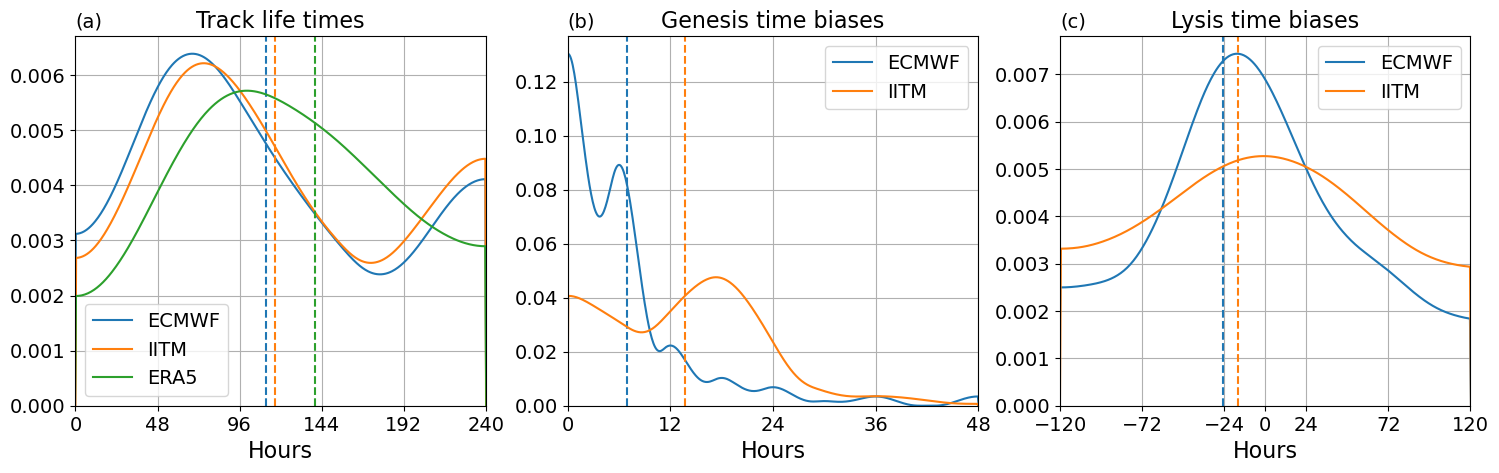

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

plot_kde(ax1, track_lengths_df, var='ECMWF', label='ECMWF', color='C0', mirror=True)
plot_kde(ax1, track_lengths_df, var='IITM', label='IITM', color='C1', mirror=True)
plot_kde(ax1, track_lengths_df, var='ERA5', label='ERA5', color='C2', mirror=True)
format_ax(ax1, title='Track life times', xlabel='Hours', xlims=[0, 240],
          interval=48, ax_label='(a)')

plot_kde(ax2, genesis_time_bias_df, var='ECMWF-ERA5', label='ECMWF', color='C0', mirror=True,
        upper_bound=48)
plot_kde(ax2, genesis_time_bias_df, var='IITM-ERA5', label='IITM', color='C1', mirror=True,
        upper_bound=48)
format_ax(ax2, title='Genesis time biases', xlabel='Hours', xlims=[0,48], 
          interval=12, ax_label='(b)')

plot_kde(ax3, lysis_time_bias_df, var='ECMWF-ERA5', label='ECMWF', color='C0', mirror=True,
        lower_bound=-120, upper_bound=120)
plot_kde(ax3, lysis_time_bias_df, var='IITM-ERA5', label='IITM', color='C1', mirror=True,
        lower_bound=-120, upper_bound=120)
format_ax(ax3, title='Lysis time biases', xlabel='Hours', xlims=[-120, 120],
          interval=48, ax_label='(c)', xtick_0=True)

# ax3.axvline(x=0, color='black', alpha=0.6) # putting a 0 tick label instead

# plt.savefig('Figures/figures_10052022/track_len_gen_lysis_dist.pdf', 
#             format='pdf', bbox_inches='tight')

## attempting to get one colorbar on the side for all three panels

helper_functions.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  #     language: python
helper_functions.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  #     language: python


AttributeError: 'GeoAxesSubplot' object has no attribute 'cax'

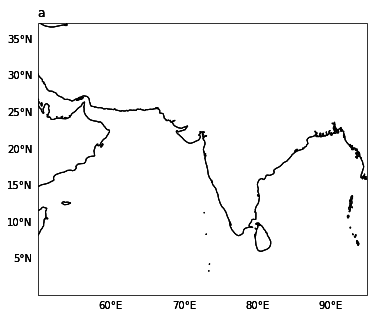

In [24]:
fig = plt.figure(figsize=[18,5])

grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                cbar_mode = 'single',
                cbar_location = 'right',
                cbar_pad = 0.1
               )

for ax in grid:
    ax = plt.axes(projection=ccrs.PlateCarree())
    format_ax(ax, 'a')
    hist_ax = plot_hist_and_tracks(ax1, fig, ERA5, 'Longitude', 'Latitude', 'ERA5', '2007')
    
cbar = ax.cax.colorbar(hist_ax[3])
cbar = grid.cbar_axes[0].colorbar(hist_ax[3])

plt.show()

## old code

In [19]:
# def three_panel_histogram_and_tracks(df1, df2, df3,
#                                      lon_var1, lat_var1,
#                                      lon_var2, lat_var2,
#                                      lon_var3, lat_var3,
#                                      year_to_plot_tracks):
    
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, subplot_kw={'projection': ccrs.PlateCarree()}, 
#                                     figsize=[24,24])

# format_ax(ax1)
# ax1.coastlines()
# ax1.set_extent([50, 95, 0, 35])
# gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# gl1.top_labels = False
# gl1.right_labels = False
# gl1.xlines = False
# gl1.ylines = False

#ax2 = plt.axes(ax2, projection=ccrs.PlateCarree())
#format_ax(ax2)
# ax2.coastlines()
# ax2.set_extent([50, 95, 0, 35])
# gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# gl2.top_labels = False
# gl2.right_labels = False
# gl2.xlines = False
# gl2.ylines = False

# ax3 = plt.axes(ax3, projection=ccrs.PlateCarree())
# format_ax(ax3)
# ax3.coastlines()
# ax3.set_extent([50, 95, 0, 35])
# gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# gl3.top_labels = False
# gl3.right_labels = False
# gl3.xlines = False
# gl3.ylines =False

#plot_hist_and_tracks(ax1, fig, ERA5, 'Longitude', 'Latitude', 'ERA5', '2007')

# hist_ax1 = ax1.hist2d(lonObs, latObs, bins=[20,15], range=[[60, 100], [0, 30]], 
#                      density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
# ax1.set_title('Observation', fontsize=17)
# fig.colorbar(histObs[3], ax=ax1, fraction=0.04, pad=0.04).set_label("Density of track points")

# for date in [x for x in iitm_hits if x[:4] == '2007']:
#     indexObs = getIndexObs(linesinfo, date)

#     trackdat = trackso[indexObs]

#     #plot genesis point: caution: it must correspond to genesis time of forecast
#     ax1.plot(trackdat[0][2],trackdat[0][3],
#              color='gray',  marker='.', markersize=markersizeg,
#              transform=ccrs.Geodetic(),
#             )

#     #make point along track for each day
#     ax1.plot(trackdat[:,2],trackdat[:,3],
#                  color='gray', linewidth=0.5,linestyle='solid',
#                  transform=ccrs.Geodetic(),
#                 )

#plot_hist_and_tracks(ax2, fig, ERA5_ECMWF, 'Longitude_ecmwf', 'Latitude_ecmwf', 'ECMWF', '2007')

# histECMWF = ax2.hist2d(mapLonFor_ecmwf, mapLatFor_ecmwf, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
# ax2.set_title('ECMWF', fontsize=17)
# fig.colorbar(histECMWF[3], ax=ax2, fraction=0.04, pad=0.04).set_label("Density of track points")

# for arr in hits_ecmwf: #for the models there's one extra layer of nesting
#         for i in range(0, len(arr)):
#             trackdat = arr[i]
#             ax2.plot(trackdat[0,2],trackdat[0,3],
#                          color='gray',  marker='.', markersize=10,
#                          transform=ccrs.Geodetic(),
#                         )
#             ax2.plot(trackdat[:,2],trackdat[:,3],
#                          color='gray', linewidth=0.5,linestyle='solid',
#                          transform=ccrs.Geodetic(),
#                         )

#plot_hist_and_tracks(ax3, fig, ERA5_IITM, 'Longitude_iitm', 'Latitude_iitm', 'IITM', '2007')

# histIITM = ax3.hist2d(mapLonFor_iitm, mapLatFor_iitm, bins=[20,15], range=[[60, 100], [0, 30]], density = True, cmin = .001, vmax = .01, cmap = plt.cm.YlOrBr)
# ax3.set_title('IITM', fontsize=17)
# fig.colorbar(histIITM[3], ax=ax3, fraction=0.04, pad=0.04).set_label("Density of track points")

# for arr in hits_iitm: #for the models there's one extra layer of nesting
#         for i in range(0, len(arr)):
#             trackdat = arr[i]
#             ax3.plot(trackdat[0,2],trackdat[0,3],
#                          color='gray',  marker='.', markersize=10,
#                          transform=ccrs.Geodetic(),
#                         )
#             ax3.plot(trackdat[:,2],trackdat[:,3],
#                          color='gray', linewidth=0.5,linestyle='solid',
#                          transform=ccrs.Geodetic(),
#                         )

#plt.savefig('Figures/contextual_density_and_tracks.pdf', format='pdf', bbox_inches='tight')